In [25]:
import jieba
import jieba.analyse
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

# 加载停用词
stopwords = set()
with open("stopwords.txt", "r", encoding="utf-8") as f:
    for line in f:
        stopwords.add(line.strip())

# 加载数据函数
def load_data(filepath):
    data, labels = [], []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) == 3:
                data.append(parts[2])
                labels.append(int(parts[1]))
    return data, labels

# 文本预处理：分词 + 去停用词 + TextRank关键词
def preprocess_data(data, use_textrank=True):
    seg_data = []
    textrank_data = []
    for text in data:
        seg_list = [word for word in jieba.cut(text) if word not in stopwords]
        seg_data.append(" ".join(seg_list))

        if use_textrank:
            keywords = " ".join(jieba.analyse.textrank(text, topK=5, withWeight=False))
            textrank_data.append(keywords)
        else:
            textrank_data.append("")
    return seg_data, textrank_data

# 读取训练与测试数据
train_data, train_labels = load_data("train.txt")
test_data, test_labels = load_data("test.txt")

# 预处理
train_seg, train_textrank = preprocess_data(train_data, use_textrank=True)
test_seg, test_textrank = preprocess_data(test_data, use_textrank=True)

# 合并 TF-IDF 与 TextRank 特征文本
combined_train_features = [seg + " " + textrank for seg, textrank in zip(train_seg, train_textrank)]
combined_test_features = [seg + " " + textrank for seg, textrank in zip(test_seg, test_textrank)]

# 向量化
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(combined_train_features)
test_features = vectorizer.transform(combined_test_features)

# 特征选择（卡方）
selector = SelectKBest(chi2, k=20)
train_features_selected = selector.fit_transform(train_features, train_labels)
test_features_selected = selector.transform(test_features)

# 打印选中特征词
feature_words = [vectorizer.get_feature_names_out()[idx] for idx in selector.get_support(indices=True)]
print("选中特征词：", feature_words)

# 供后续 Cell 使用的全局变量：
# train_features_selected, test_features_selected, train_labels, test_labels, feature_words


选中特征词： ['cnmd', 'cry', 'doge', 'mmp', 'sb', '伤心', '分手', '别人', '去死吧', '呵呵', '哈哈哈', '哈哈哈哈', '哭哭', '失望', '微笑', '心碎', '恶心', '拜拜', '摊手', '难受']


In [26]:
# Cell 2: 逻辑回归

'''
# 直接调用 sklearn 的逻辑回归进行对比
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

lr = LogisticRegression(max_iter=1000, penalty='l2', solver='liblinear')
lr.fit(train_features_selected, np.array(train_labels))

lr_pred = lr.predict(test_features_selected)
lr_proba = lr.predict_proba(test_features_selected)[:, 1]  # 正类概率

lr_precision = precision_score(test_labels, lr_pred)
lr_recall = recall_score(test_labels, lr_pred)
lr_f1 = f1_score(test_labels, lr_pred)
print(f"逻辑回归 -> Precision: {lr_precision:.4f}, Recall: {lr_recall:.4f}, F1: {lr_f1:.4f}")
'''

# Cell 2: 手写逻辑回归（不调用 sklearn LogisticRegression）
import numpy as np

# 将稀疏特征矩阵转为稠密数组（方便手写计算）
X_train = train_features_selected.toarray()
X_test = test_features_selected.toarray()
y_train = np.array(train_labels, dtype=np.float64)
y_test = np.array(test_labels, dtype=np.float64)

# ===== 手写逻辑回归类 =====
class ManualLogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=1000, reg_lambda=1.0, verbose=False):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.reg_lambda = reg_lambda  # L2 正则化参数
        self.verbose = verbose
        self.w = None  # 权重
        self.b = 0.0  # 偏置

    @staticmethod
    def sigmoid(z): #激活函数
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        m, n = X.shape
        self.w = np.zeros(n, dtype=np.float64)
        self.b = 0.0

        for it in range(self.max_iter):
            # 线性模型
            z = X.dot(self.w) + self.b
            h = self.sigmoid(z)  # 正类概率

            # 交叉熵损失 + L2正则化
            eps = 1e-12
            loss = (-1.0 / m) * (np.sum(y * np.log(h + eps) + (1 - y) * np.log(1 - h + eps)))
            loss += (self.reg_lambda / (2.0 * m)) * np.sum(self.w ** 2)

            # 梯度计算
            error = h - y  # m维
            dw = (1.0 / m) * (X.T.dot(error)) + (self.reg_lambda / m) * self.w  # n维
            db = (1.0 / m) * np.sum(error)

            # 参数更新
            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db

            if self.verbose and (it % 100 == 0 or it == self.max_iter - 1):
                print(f"Iter {it}: loss={loss:.6f}")

    def predict_proba(self, X):
        z = X.dot(self.w) + self.b
        return self.sigmoid(z)  # 正类概率

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

# ===== 指标计算 =====
def precision_recall_f1(y_true, y_pred):
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    return precision, recall, f1

# ===== 训练 & 预测 =====
lr = ManualLogisticRegression(learning_rate=0.1, max_iter=1000, reg_lambda=1.0, verbose=False)
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)  # 正类概率，供 ROC/P-R 曲线使用

# ===== 输出性能指标 =====
lr_precision, lr_recall, lr_f1 = precision_recall_f1(y_test, lr_pred)
print(f"逻辑回归(手写) -> Precision: {lr_precision:.4f}, Recall: {lr_recall:.4f}, F1: {lr_f1:.4f}")


逻辑回归(手写) -> Precision: 0.5247, Recall: 1.0000, F1: 0.6882


In [27]:
# Cell 3: 朴素贝叶斯 HandwrittenMultinomialNB

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

class HandwrittenMultinomialNB:
    def __init__(self):
        self.class_log_prior_ = None
        self.feature_log_prob_ = None
        self.classes_ = None
        self.feature_count_ = None
        self.class_count_ = None

    def fit(self, X, y):
        # X 可以是稀疏矩阵
        m, n = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.feature_count_ = np.zeros((n_classes, n))
        self.class_count_ = np.zeros(n_classes)

        # 逐类统计词频与样本数
        for i, cls in enumerate(self.classes_):
            Xi = X[np.array(y) == cls]
            sums = Xi.sum(axis=0)  # 稀疏矩阵求和
            self.feature_count_[i, :] = np.asarray(sums).ravel()
            self.class_count_[i] = Xi.shape[0]

        # 先验概率（log）
        self.class_log_prior_ = np.log(self.class_count_ / self.class_count_.sum())

        # 条件概率（拉普拉斯平滑）再取 log
        smoothed_fc = self.feature_count_ + 1.0
        smoothed_totals = smoothed_fc.sum(axis=1, keepdims=True)
        self.feature_log_prob_ = np.log(smoothed_fc / smoothed_totals)

    def _joint_log_likelihood(self, X):
        # 计算每个样本对每个类别的联合对数似然
        is_sparse = hasattr(X, 'getrow')
        jll_list = []
        for i in range(X.shape[0]):
            row = X.getrow(i) if is_sparse else X[i]
            # row: 1 x n, feature_log_prob_: c x n => 1 x c
            log_prob = row.dot(self.feature_log_prob_.T)
            log_prob = np.asarray(log_prob).ravel()
            log_prob += self.class_log_prior_
            jll_list.append(log_prob)
        return np.vstack(jll_list)

    def predict(self, X):
        jll = self._joint_log_likelihood(X)
        idx = np.argmax(jll, axis=1)
        return self.classes_[idx]

    def predict_proba(self, X):
        jll = self._joint_log_likelihood(X)
        # 从 log 概率转为概率，并归一化
        probs = np.exp(jll)
        probs /= probs.sum(axis=1, keepdims=True)
        return probs

# 训练 & 预测
nb = HandwrittenMultinomialNB()
nb.fit(train_features_selected, np.array(train_labels))

nb_pred = nb.predict(test_features_selected)
nb_proba = nb.predict_proba(test_features_selected)[:, 1]  # 正类概率（假设正类标签为1）

# 指标
nb_precision = precision_score(test_labels, nb_pred)
nb_recall = recall_score(test_labels, nb_pred)
nb_f1 = f1_score(test_labels, nb_pred)
print(f"朴素贝叶斯 -> Precision: {nb_precision:.4f}, Recall: {nb_recall:.4f}, F1: {nb_f1:.4f}")



朴素贝叶斯 -> Precision: 0.6078, Recall: 0.9913, F1: 0.7536


In [28]:
'''
# Cell 4: 手写决策树

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def gini_impurity(y):
    # 基尼指数
    classes, counts = np.unique(y, return_counts=True)
    total = len(y)
    impurity = 1.0 - np.sum((counts / total) ** 2)
    return impurity

def split_gini(X, y, feature_index, threshold):
    # 按某特征阈值划分后的加权基尼
    left_idx = X[:, feature_index] < threshold
    right_idx = ~left_idx

    left_y = y[left_idx]
    right_y = y[right_idx]

    n_left, n_right = len(left_y), len(right_y)
    n_total = n_left + n_right
    if n_total == 0:
        return float("inf")

    g_left = gini_impurity(left_y) if n_left > 0 else 0.0
    g_right = gini_impurity(right_y) if n_right > 0 else 0.0

    weighted_gini = (n_left / n_total) * g_left + (n_right / n_total) * g_right
    return weighted_gini

class TreeNode:
    def __init__(self, gini, num_samples, class_counts, predicted_class, classes):
        self.gini = gini
        self.num_samples = num_samples
        self.class_counts = class_counts  # 与 classes 对齐的计数
        self.predicted_class = predicted_class  # 实际类别标签
        self.classes = classes  # 类别顺序
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None

def find_best_split(X, y, n_features):
    best_feature_index, best_threshold, best_gini = None, None, float("inf")
    for fi in range(n_features):
        thresholds = np.unique(X[:, fi])
        for t in thresholds:
            g = split_gini(X, y, fi, t)
            if g < best_gini:
                best_gini = g
                best_feature_index = fi
                best_threshold = t
    return best_feature_index, best_threshold

def build_tree(X, y, classes=None, depth=0, max_depth=15, min_samples_split=50):
    X = np.array(X)
    y = np.array(y)

    if classes is None:
        classes = np.unique(y)

    # 停止条件
    if len(X) == 0 or len(X) < min_samples_split or depth >= max_depth or len(np.unique(y)) == 1:
        # 叶子节点
        class_counts = np.array([np.sum(y == c) for c in classes])
        predicted_class = classes[np.argmax(class_counts)] if class_counts.sum() > 0 else classes[0]
        return TreeNode(
            gini=gini_impurity(y) if len(y) > 0 else 0.0,
            num_samples=len(y),
            class_counts=class_counts,
            predicted_class=predicted_class,
            classes=classes
        )

    # 当前节点
    class_counts = np.array([np.sum(y == c) for c in classes])
    predicted_class = classes[np.argmax(class_counts)]
    node = TreeNode(
        gini=gini_impurity(y),
        num_samples=len(y),
        class_counts=class_counts,
        predicted_class=predicted_class,
        classes=classes
    )

    # 寻找最优划分
    n_features = X.shape[1]
    fi, t = find_best_split(X, y, n_features)
    if fi is None:
        return node

    # 划分数据
    left_idx = X[:, fi] < t
    right_idx = ~left_idx

    node.feature_index = fi
    node.threshold = t
    node.left = build_tree(X[left_idx], y[left_idx], classes, depth + 1, max_depth, min_samples_split)
    node.right = build_tree(X[right_idx], y[right_idx], classes, depth + 1, max_depth, min_samples_split)
    return node

def predict_tree(sample, node):
    cur = node
    while cur.left is not None and cur.right is not None:
        if sample[cur.feature_index] < cur.threshold:
            cur = cur.left
        else:
            cur = cur.right
    return cur.predicted_class

def predict_tree_proba(sample, node):
    cur = node
    while cur.left is not None and cur.right is not None:
        if sample[cur.feature_index] < cur.threshold:
            cur = cur.left
        else:
            cur = cur.right
    totals = cur.class_counts.sum()
    if totals == 0:
        return np.ones(len(cur.classes)) / len(cur.classes)
    return cur.class_counts / totals

# ======= 训练决策树 =======
classes_global = np.unique(train_labels)
tree = build_tree(train_features_selected.toarray(), train_labels, classes=classes_global)

# ======= 预测标签 =======
dt_pred = [predict_tree(instance, tree) for instance in test_features_selected.toarray()]

# ======= 预测概率（取正类概率） =======
dt_proba = [predict_tree_proba(instance, tree)[list(classes_global).index(1)] 
            for instance in test_features_selected.toarray()]

# ======= 性能指标 =======
dt_precision = precision_score(test_labels, dt_pred)
dt_recall = recall_score(test_labels, dt_pred)
dt_f1 = f1_score(test_labels, dt_pred)

print(f"决策树 -> Precision: {dt_precision:.4f}, Recall: {dt_recall:.4f}, F1: {dt_f1:.4f}")
'''


'\n# Cell 4: 手写决策树\n\nimport numpy as np\nfrom sklearn.metrics import precision_score, recall_score, f1_score\n\ndef gini_impurity(y):\n    # 基尼指数\n    classes, counts = np.unique(y, return_counts=True)\n    total = len(y)\n    impurity = 1.0 - np.sum((counts / total) ** 2)\n    return impurity\n\ndef split_gini(X, y, feature_index, threshold):\n    # 按某特征阈值划分后的加权基尼\n    left_idx = X[:, feature_index] < threshold\n    right_idx = ~left_idx\n\n    left_y = y[left_idx]\n    right_y = y[right_idx]\n\n    n_left, n_right = len(left_y), len(right_y)\n    n_total = n_left + n_right\n    if n_total == 0:\n        return float("inf")\n\n    g_left = gini_impurity(left_y) if n_left > 0 else 0.0\n    g_right = gini_impurity(right_y) if n_right > 0 else 0.0\n\n    weighted_gini = (n_left / n_total) * g_left + (n_right / n_total) * g_right\n    return weighted_gini\n\nclass TreeNode:\n    def __init__(self, gini, num_samples, class_counts, predicted_class, classes):\n        self.gini = gini\n    

In [29]:
# Cell 4.5: 决策树+随机森林 (统一阈值版)

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy import stats

# ==========================================
# 0. 全局参数设置 (修改此处即可控制两个模型)
# ==========================================
PREDICTION_THRESHOLD = 0.5  # [核心] 统一判定阈值 (大于此值才判为正类)
RF_N_ESTIMATORS = 20        # 随机森林树的数量
GLOBAL_MAX_DEPTH = 15       # 树的最大深度
GLOBAL_MIN_SAMPLES = 80     # 节点分裂最小样本数 (越大越防过拟合)

# ==========================================
# 1. 基础组件
# ==========================================

def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    total = len(y)
    impurity = 1.0 - np.sum((counts / total) ** 2)
    return impurity

def split_gini(X, y, feature_index, threshold):
    left_idx = X[:, feature_index] < threshold
    right_idx = ~left_idx
    left_y = y[left_idx]
    right_y = y[right_idx]
    n_left, n_right = len(left_y), len(right_y)
    n_total = n_left + n_right
    if n_total == 0: return float("inf")
    g_left = gini_impurity(left_y) if n_left > 0 else 0.0
    g_right = gini_impurity(right_y) if n_right > 0 else 0.0
    weighted_gini = (n_left / n_total) * g_left + (n_right / n_total) * g_right
    return weighted_gini

class TreeNode:
    def __init__(self, gini, num_samples, class_counts, predicted_class, classes):
        self.gini = gini
        self.num_samples = num_samples
        self.class_counts = class_counts
        self.predicted_class = predicted_class
        self.classes = classes
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None

def find_best_split(X, y, n_features):
    best_feature_index, best_threshold, best_gini = None, None, float("inf")
    for fi in range(n_features):
        thresholds = np.unique(X[:, fi])
        for t in thresholds:
            g = split_gini(X, y, fi, t)
            if g < best_gini:
                best_gini = g
                best_feature_index = fi
                best_threshold = t
    return best_feature_index, best_threshold

def build_tree(X, y, classes=None, depth=0, max_depth=15, min_samples_split=50):
    X = np.array(X)
    y = np.array(y)
    if classes is None: classes = np.unique(y)

    if len(X) == 0 or len(X) < min_samples_split or depth >= max_depth or len(np.unique(y)) == 1:
        class_counts = np.array([np.sum(y == c) for c in classes])
        predicted_class = classes[np.argmax(class_counts)] if class_counts.sum() > 0 else classes[0]
        return TreeNode(gini_impurity(y) if len(y) > 0 else 0.0, len(y), class_counts, predicted_class, classes)

    class_counts = np.array([np.sum(y == c) for c in classes])
    predicted_class = classes[np.argmax(class_counts)]
    node = TreeNode(gini_impurity(y), len(y), class_counts, predicted_class, classes)

    n_features = X.shape[1]
    fi, t = find_best_split(X, y, n_features)
    if fi is None: return node

    left_idx = X[:, fi] < t
    right_idx = ~left_idx
    node.feature_index = fi
    node.threshold = t
    node.left = build_tree(X[left_idx], y[left_idx], classes, depth + 1, max_depth, min_samples_split)
    node.right = build_tree(X[right_idx], y[right_idx], classes, depth + 1, max_depth, min_samples_split)
    return node

# [新增] 用于单棵树获取概率，以便应用阈值
def predict_tree_proba_single(sample, node):
    cur = node
    while cur.left is not None and cur.right is not None:
        if sample[cur.feature_index] < cur.threshold:
            cur = cur.left
        else:
            cur = cur.right
    
    total = cur.class_counts.sum()
    if total == 0: return 0.0
    
    # 寻找正类 (假设标签1是正类) 的索引
    try:
        # 假设 classes 中包含 1
        pos_idx = list(cur.classes).index(1)
        return cur.class_counts[pos_idx] / total
    except ValueError:
        # 如果该节点没有正类记录
        return 0.0

def predict_tree_class(sample, node):
    # 直接预测类的方法，保留备用
    cur = node
    while cur.left is not None and cur.right is not None:
        if sample[cur.feature_index] < cur.threshold:
            cur = cur.left
        else:
            cur = cur.right
    return cur.predicted_class

# ==========================================
# 2. 随机森林类
# ==========================================

class ManualRandomForest:
    def __init__(self, n_estimators=20, max_depth=15, min_samples_split=80):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = X.shape[0]
        self.trees = []
        
        print(f"随机森林参数： (Trees={self.n_estimators}, Depth={self.max_depth})...")
        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            tree = build_tree(X_sample, y_sample, classes=self.classes, 
                              max_depth=self.max_depth, 
                              min_samples_split=self.min_samples_split)
            self.trees.append(tree)

    def predict_proba(self, X):
        pos_label = 1 # 假设正类为 1
        votes = np.zeros(X.shape[0])
        for tree in self.trees:
            preds = np.array([predict_tree_class(sample, tree) for sample in X])
            votes += (preds == pos_label).astype(int)
        return votes / self.n_estimators

    def predict(self, X, threshold=0.5):
        probas = self.predict_proba(X)
        pos_label = 1
        neg_label = 0 # 假设负类为 0
        return np.where(probas > threshold, pos_label, neg_label)

# ==========================================
# 3. 统一执行与对比
# ==========================================

X_train_dense = train_features_selected.toarray()
X_test_dense = test_features_selected.toarray()
classes_global = np.unique(train_labels)

print(f"=== 当前阈值 (Threshold): {PREDICTION_THRESHOLD} ===")

# --- A. 单棵决策树 ---
print("===训练单棵决策树===")
tree = build_tree(X_train_dense, train_labels, classes=classes_global, 
                  max_depth=GLOBAL_MAX_DEPTH, 
                  min_samples_split=GLOBAL_MIN_SAMPLES)

# 获取概率
dt_probas = [predict_tree_proba_single(instance, tree) for instance in X_test_dense]
# 应用全局阈值
dt_pred = (np.array(dt_probas) > PREDICTION_THRESHOLD).astype(int)

dt_p = precision_score(test_labels, dt_pred)
dt_r = recall_score(test_labels, dt_pred)
dt_f = f1_score(test_labels, dt_pred)
print(f"决策树       -> Precision: {dt_p:.4f}, Recall: {dt_r:.4f}, F1: {dt_f:.4f}")

# --- B. 随机森林 ---
print("===随机森林===")
rf = ManualRandomForest(n_estimators=RF_N_ESTIMATORS, 
                        max_depth=GLOBAL_MAX_DEPTH, 
                        min_samples_split=GLOBAL_MIN_SAMPLES)
rf.fit(X_train_dense, np.array(train_labels))

# 应用全局阈值
rf_pred = rf.predict(X_test_dense, threshold=PREDICTION_THRESHOLD)

rf_p = precision_score(test_labels, rf_pred)
rf_r = recall_score(test_labels, rf_pred)
rf_f = f1_score(test_labels, rf_pred)
print(f"随机森林     -> Precision: {rf_p:.4f}, Recall: {rf_r:.4f}, F1: {rf_f:.4f}")


=== 当前阈值 (Threshold): 0.5 ===
===训练单棵决策树===
决策树       -> Precision: 0.6289, Recall: 0.9711, F1: 0.7634
===随机森林===
随机森林参数： (Trees=20, Depth=15)...
随机森林     -> Precision: 0.6289, Recall: 0.9711, F1: 0.7634


=== 三种算法性能对比 ===
算法          Precision     Recall         F1
朴素贝叶斯          0.6078     0.9913     0.7536
逻辑回归           0.5247     1.0000     0.6882
决策树            0.6289     0.9711     0.7634


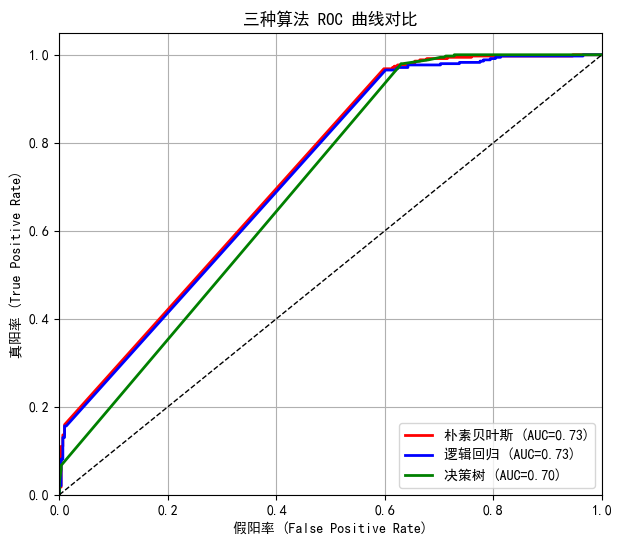

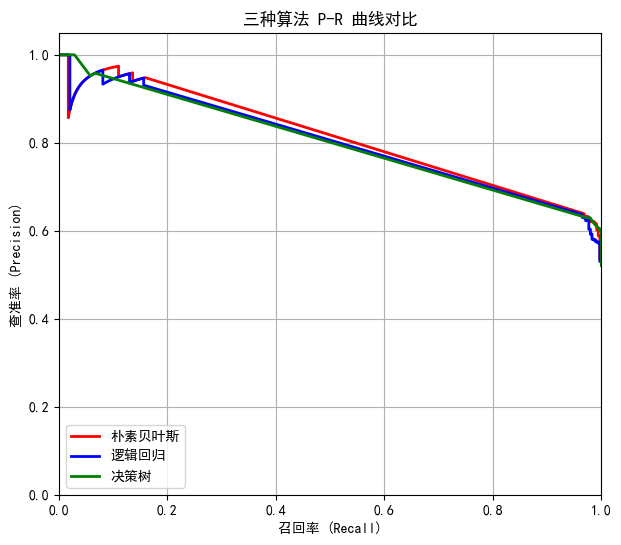

In [30]:
# Cell 5: 三算法性能对比 + ROC曲线 + P-R曲线
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ==== 中文字体 & 负号处理 ====
matplotlib.rcParams['font.family'] = 'SimHei'  # 黑体，用于中文显示
matplotlib.rcParams['axes.unicode_minus'] = False  # 允许显示负号

# ==== 性能数值对比 ====
alg_results = {
    "朴素贝叶斯": (precision_score(test_labels, nb_pred), recall_score(test_labels, nb_pred), f1_score(test_labels, nb_pred)),
    "逻辑回归": (precision_score(test_labels, lr_pred), recall_score(test_labels, lr_pred), f1_score(test_labels, lr_pred)),
    "决策树": (precision_score(test_labels, dt_pred), recall_score(test_labels, dt_pred), f1_score(test_labels, dt_pred)),
}

print("=== 三种算法性能对比 ===")
print("{:<10} {:>10} {:>10} {:>10}".format("算法", "Precision", "Recall", "F1"))
for name, (p, r, f) in alg_results.items():
    print("{:<10} {:>10.4f} {:>10.4f} {:>10.4f}".format(name, p, r, f))

# ==== ROC曲线 ====
plt.figure(figsize=(7,6))
for name, proba, color in zip(
    ["朴素贝叶斯", "逻辑回归", "决策树"],
    [nb_proba, lr_proba, dt_proba],
    ['red', 'blue', 'green']
):
    fpr, tpr, _ = roc_curve(test_labels, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳率 (False Positive Rate)')
plt.ylabel('真阳率 (True Positive Rate)')
plt.title('三种算法 ROC 曲线对比')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ==== P-R曲线 ====
plt.figure(figsize=(7,6))
for name, proba, color in zip(
    ["朴素贝叶斯", "逻辑回归", "决策树"],
    [nb_proba, lr_proba, dt_proba],
    ['red', 'blue', 'green']
):
    precisions, recalls, _ = precision_recall_curve(test_labels, proba)
    plt.plot(recalls, precisions, color=color, lw=2, label=f'{name}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('召回率 (Recall)')
plt.ylabel('查准率 (Precision)')
plt.title('三种算法 P-R 曲线对比')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()
